In [1]:
## reading a CSV file

#we can represent cvs as a list of rows or a dictionary


import unicodecsv

'''
enrollments = []
f = open('enrollments.csv','rb') #rb means that the file can be open for reading
reader = unicodecsv.DictReader(f) #row will be dictionary, since data has header
# reader will be a iterator 
for row in reader:
    enrollments.append(row)
    
for row in reader:  #this does not work, because you can only loop iterator once
    print row
    
f.close()

enrollments[0]
'''

# note that we can re-write our function above:

def read_csv(filename):
    with open(filename, 'rb') as f: #using with for file can avoid writing f.close()
        reader = unicodecsv.DictReader(f)
        return list(reader) #convert iterator to a list, avoid using for loop to append

enrollments = read_csv('enrollments.csv')
daily_engagement = read_csv('daily-engagement.csv')
project_submissions = read_csv('project-submissions.csv')





## 修正数据类型


In [2]:
from datetime import datetime as dt

# 将字符串格式的时间转为 Python datetime 类型的时间。
# 如果没有时间字符串传入，返回 None

def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%Y-%m-%d')#convert date to new format
    
# 将可能是空字符串或字符串类型的数据转为 整型 或 None。

def parse_maybe_int(i):
    if i == '':
        return None
    else:
        return int(i)

# 清理 enrollments 表格中的数据类型

for enrollment in enrollments:
    enrollment['cancel_date'] = parse_date(enrollment['cancel_date'])
    enrollment['days_to_cancel'] = parse_maybe_int(enrollment['days_to_cancel'])
    enrollment['is_canceled'] = enrollment['is_canceled'] == 'True'
    enrollment['is_udacity'] = enrollment['is_udacity'] == 'True'
    enrollment['join_date'] = parse_date(enrollment['join_date'])
    
enrollments[0]

{u'account_key': u'448',
 u'cancel_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'days_to_cancel': 65,
 u'is_canceled': True,
 u'is_udacity': True,
 u'join_date': datetime.datetime(2014, 11, 10, 0, 0),
 u'status': u'canceled'}

In [3]:
# 清理 engagement 的数据类型
for engagement_record in daily_engagement:
    engagement_record['lessons_completed'] = int(float(engagement_record['lessons_completed']))
    engagement_record['num_courses_visited'] = int(float(engagement_record['num_courses_visited']))
    engagement_record['projects_completed'] = int(float(engagement_record['projects_completed']))
    engagement_record['total_minutes_visited'] = float(engagement_record['total_minutes_visited'])
    engagement_record['utc_date'] = parse_date(engagement_record['utc_date'])
    
daily_engagement[0]

{u'acct': u'0',
 u'lessons_completed': 0,
 u'num_courses_visited': 1,
 u'projects_completed': 0,
 u'total_minutes_visited': 11.6793745,
 u'utc_date': datetime.datetime(2015, 1, 9, 0, 0)}

In [4]:
# 清理 submissions 的数据类型
for submission in project_submissions:
    submission['completion_date'] = parse_date(submission['completion_date'])
    submission['creation_date'] = parse_date(submission['creation_date'])

project_submissions[0]

{u'account_key': u'256',
 u'assigned_rating': u'UNGRADED',
 u'completion_date': datetime.datetime(2015, 1, 16, 0, 0),
 u'creation_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'lesson_key': u'3176718735',
 u'processing_state': u'EVALUATED'}

注意：当我们在运行上方的单元格时，我们已经改变了数据变量中的内容。如果你试着在同一个会话多次运行这些单元格时，可能会出错。

## 探索数据

In [5]:


## 计算每张表中的总行数，和独立学生（拥有独立的 account keys）的数量

def distinct_key(dataset):
    account = []
    try:
        for item in dataset:
            account_key = item['account_key']
            if account_key not in account:
                account.append(account_key)
        return len(dataset), len(account)
    except:
        for item in dataset:
            account_key = item['acct']
            if account_key not in account:
                account.append(account_key)
        return len(dataset), len(account)
        

## 数据中的问题

In [6]:

'''change acct to account_key'''

for engagement_record in daily_engagement:
    engagement_record['account_key'] = engagement_record['acct']
    del engagement_record['acct']
    
print daily_engagement[0]['account_key']

0


In [7]:
'''why are students missing from daily-engagement table?'''
key = []
for x in daily_engagement:
    key.append(x['account_key'])
print len(enrollments)



test_account = []
for item in enrollments:
    if item['account_key'] not in key:
        if item['join_date'] != item['cancel_date']:
            test_account.append(item['account_key'])
print test_account

def remove_test_account(dataset):
    new_dataset = []
    for item in dataset:
        if item['is_udacity'] == False:
            new_dataset.append(item)
            
    return new_dataset

revised_enrollments = remove_test_account(enrollments)

print len(remove_test_account(enrollments))



# 为所有 Udacity 测试帐号建立一组 set 
udacity_test_accounts = set()
for enrollment in enrollments:
    if enrollment['is_udacity']:
        udacity_test_accounts.add(enrollment['account_key'])
len(udacity_test_accounts)

def revise_dataset(data):
    non_udacity_data = []
    for data_point in data:
        if data_point['account_key'] not in udacity_test_accounts:
            non_udacity_data.append(data_point)
    return non_udacity_data

revised_engagements = revise_dataset(daily_engagement)
revised_submissions = revise_dataset(project_submissions)



1640
[u'1304', u'1304', u'1101']
1622


# Further Investigate


### how do numbers in the daily engagement table differ for students who eventually pass the first project and who do not?
    
problem 1: This will include data from after the project submission

problem 2: This compares data from different lengths of time

problem 3: Includes engagement in courses not related to the first project

### Revision: only look at engagement from first week, and exclude students who cancel within a week

getting started:

Created a dictionary of students who either:
* have not canceled yet
* stayed enrolled more than 7 days

keys: account_key; values: enrollment date


In [8]:

def dict_valid_enroll(dataset):
    dic = {}
    for item in dataset:
        if (not item['is_canceled'] or 
                item['days_to_cancel'] > 7):
                key = item['account_key']
                value = item['join_date']
                if key not in dic:
                    dic[key] = value
                else:
                    if dic[key] < value:
                        dic[key] = value
    return dic

print len(dict_valid_enroll(revised_enrollments))
paid_students = dict_valid_enroll(revised_enrollments)


995


## 获取第1周的数据
获取第1周的数据

In [9]:
# 基于学生的加入日期和特定一天的互动记录，
# 若该互动记录发生在学生加入1周内，则反回 True

def within_one_week(join_date, engagement_date):
    time_delta = engagement_date - join_date
    return time_delta.days < 7 and time_delta.days >= 0

In [10]:
## 创建一个 engagement 记录的列表，
## 该列表只包括付费学生以及加入的前7天的学生的记录
## 输入符合要求的行数

def lisof_paid_students(dataset):
    new = []
    for item in dataset:
        if item['account_key'] in paid_students:
            new.append(item)
    return new



paid_enrollment = lisof_paid_students(revised_enrollments)
paid_engagement = lisof_paid_students(revised_engagements)
paid_submission = lisof_paid_students(revised_submissions)


def record_within_7days():
    lis = []
    for item in paid_engagement:
        engagement_date = item['utc_date']
        key = item['account_key']
        join_date = paid_students[key]
        if within_one_week(join_date,engagement_date):
            lis.append(item)
    return lis

print len(record_within_7days())

paid_engagement_in_first_week = record_within_7days()
#print paid_engagement_in_first_week

## now I will add new field to check whether a student taking classes 
##   or not for each day

for item in paid_engagement_in_first_week:
    num_of_courses = item['lessons_completed']
    if num_of_courses > 0:
        item['whether_study'] = True
    else:
        item['whether_study'] = False



6919


## Exploring Student Engagement

In [11]:
from collections import defaultdict

# 创建基于 student 对 engagement 进行分组的字典，字典的键为帐号（account key），值为包含互动记录的列表

def classify_engagement(data, key):
    engagement_by_account = defaultdict(list)
    for engagement_record in data:
        account_key = engagement_record[key]
        engagement_by_account[account_key].append(engagement_record)
    return engagement_by_account

account_key = 'account_key'
engagement_by_account = classify_engagement(paid_engagement_in_first_week, account_key)



In [12]:
# 创建一个包含学生在第1周在教室所花总时间和字典。键为帐号（account key），值为数字（所花总时间）

def sum_value(data, key):
    total_minutes_by_account = {}
    for account_key, engagement_for_student in data.items():
        total_minutes = 0
        for engagement_record in engagement_for_student:
            total_minutes += engagement_record[key]
        total_minutes_by_account[account_key] = total_minutes
    return total_minutes_by_account    
    
key = 'total_minutes_visited'
total_minutes_by_account = sum_value(engagement_by_account, key) 

Populating the interactive namespace from numpy and matplotlib
Mean: 306.708326753
Standard deviation: 412.996933409
Minimum: 0.0
Maximum: 3564.7332645


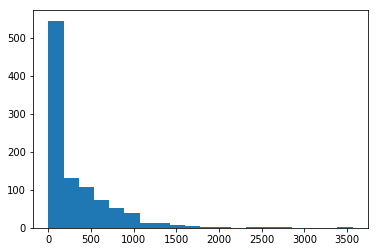

In [64]:
import numpy as np

# 汇总和描述关于教室所花时间的数据
total_minutes = total_minutes_by_account.values()


%pylab inline

import matplotlib.pyplot as plt
import numpy as np

# Summarize the given data
def describe_data(data):
    print 'Mean:', np.mean(data)
    print 'Standard deviation:', np.std(data)
    print 'Minimum:', np.min(data)
    print 'Maximum:', np.max(data)
    plt.hist(data,bins=20)
describe_data(total_minutes)
#note that max number is greater than total minutes of a week =>error

## Fix Code

In [65]:
#note that max number is greater than total minutes of a week =>error
#lets print out that student with that irregular max study time
key
max_min = 0
for item in total_minutes_by_account:
    if max_min < total_minutes_by_account[item]:
        max_min = total_minutes_by_account[item]
        key = item
#print key
#print engagement_by_account[key]

## the printed result including the study not only within first week 
## but up to several month later
## hence, we did not only get the result as first week
## lets check the fucntion checking whether it is within 7 days

## 第1周完成的课程数（Lessons）



Mean: 1.63618090452
Standard deviation: 3.00256129983
Minimum: 0
Maximum: 36


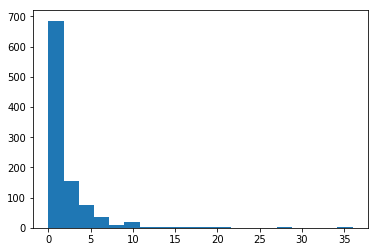

In [66]:
## 修改之前的代码，找出第1周学生完成课程数的 平均值、标准差、最小值、最大值。尝试创建一个或更多的函数来复用之前的代码

account_key = 'account_key'
engagement_by_account = classify_engagement(paid_engagement_in_first_week, account_key)

key = 'lessons_completed'
total_lessons_by_account = sum_value(engagement_by_account, key) 

import numpy as np
total_lessons = total_lessons_by_account.values()
describe_data(total_lessons)


## 第1周的访问次数
I will add a field of 0 or 1 to represent whether a student takes classes or not on each day. Then i will call the above two functions to print out all info



Mean: 1.08040201005
Standard deviation: 1.47596075148
Minimum: 0
Maximum: 7


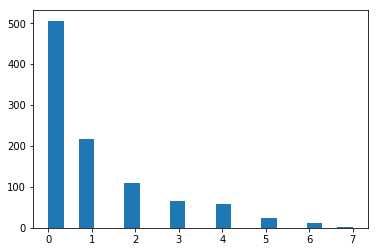

In [67]:
account_key = 'account_key'
engagement_by_account = classify_engagement(paid_engagement_in_first_week, account_key)

key = 'whether_study'
study_days_by_account = sum_value(engagement_by_account, key) 

import numpy as np
study_days = study_days_by_account.values()

describe_data(study_days)

## 区分项目通过的学生

In [68]:
## 创建两个付费学生第1周的互动数据列表（engagement）。第1个包含通过项目的学生，第2个包含没通过项目的学生。

subway_project_lesson_keys = ['746169184', '3176718735']


## you must use set instead of list because key should not be repeated but individual may
##  submit the first project multiple times, you do not have to include key for all those times
passing_engagement = set()
non_passing_engagement = []

for item in paid_submission:
    lec_key = item['lesson_key']
    if lec_key not in subway_project_lesson_keys:
        continue
    sub_status = item['assigned_rating']
    if sub_status == 'PASSED' or sub_status == 'DISTINCTION':
        passing_engagement.add(item['account_key'])
        
len(pass_subway_project)

passing_engagement = []
non_passing_engagement = []

for engagement_record in paid_engagement_in_first_week:
    if engagement_record['account_key'] in pass_subway_project:
        passing_engagement.append(engagement_record)
    else:
        non_passing_engagement.append(engagement_record)

print len(passing_engagement)
print len(non_passing_engagement)





4527
2392


# compare some facts between student passed the project the those who do not

Mean: 2.05255023184
Standard deviation: 3.14222705558
Minimum: 0
Maximum: 36


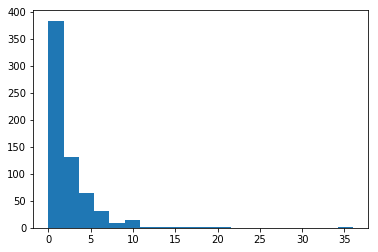

In [69]:
account_key = 'account_key'
engagement_by_account2 = classify_engagement(passing_engagement, account_key)

key = 'lessons_completed'
total_lessons_by_account2 = sum_value(engagement_by_account2, key) 

import numpy as np
total_lessons2 = total_lessons_by_account2.values()
describe_data(total_lessons2)

Mean: 0.862068965517
Standard deviation: 2.54915994183
Minimum: 0
Maximum: 27


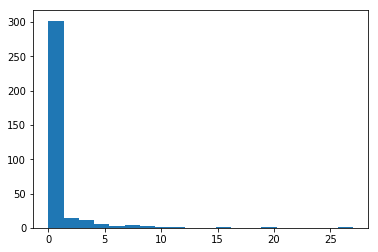

In [70]:
account_key = 'account_key'
engagement_by_account3 = classify_engagement(non_passing_engagement, account_key)

key = 'lessons_completed'
total_lessons_by_account3 = sum_value(engagement_by_account3, key) 

import numpy as np
total_lessons3 = total_lessons_by_account3.values()
describe_data(total_lessons3)

## 制作直方图

Populating the interactive namespace from numpy and matplotlib


(array([ 506.,  217.,  110.,    0.,   65.,   59.,    0.,   24.,   11.,    3.]),
 array([ 0. ,  0.7,  1.4,  2.1,  2.8,  3.5,  4.2,  4.9,  5.6,  6.3,  7. ]),
 <a list of 10 Patch objects>)

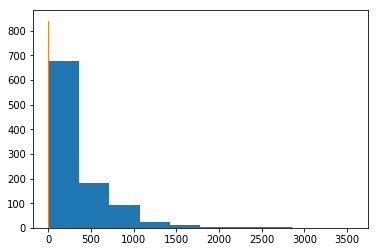

In [75]:
## 针对通过项目和没有通过项目的两组学生，为我们之前研究的三个数据指标制作直方图。
## 你也可以为其它你所检验的数据指标来制作直方图。

'''
matplotlib.pyplot.hist(x, bins=None, range=None, normed=False, 
weights=None, cumulative=False, bottom=None, histtype='bar', 
align='mid', orientation='vertical', rwidth=None, log=False, 
color=None, label=None, stacked=False, hold=None, data=None, **kwargs)

x : (n,) array or sequence of (n,) arrays

Input values, this takes either a single array or a sequency of arrays which are not required to be of the same length

bins : integer or array_like or ‘auto’, optional

If an integer is given, bins + 1 bin edges are returned, consistently with numpy.histogram() for numpy version >= 1.3.

Unequally spaced bins are supported if bins is a sequence.

If Numpy 1.11 is installed, may also be 'auto'.

Default is taken from the rcParam hist.bins.

range : tuple or None, optional

The lower and upper range of the bins. Lower and upper outliers are ignored. If not provided, range is (x.min(), x.max()). Range has no effect if bins is a sequence.

If bins is a sequence or range is specified, autoscaling is based on the specified bin range instead of the range of x.

Default is None

normed : boolean, optional

If True, the first element of the return tuple will be the counts normalized to form a probability density, i.e., n/(len(x)`dbin), i.e., the integral of the histogram will sum to 1. If stacked is also True, the sum of the histograms is normalized to 1.

Default is False

weights : (n, ) array_like or None, optional

An array of weights, of the same shape as x. Each value in x only contributes its associated weight towards the bin count (instead of 1). If normed is True, the weights are normalized, so that the integral of the density over the range remains 1.

Default is None

cumulative : boolean, optional

If True, then a histogram is computed where each bin gives the counts in that bin plus all bins for smaller values. The last bin gives the total number of datapoints. If normed is also True then the histogram is normalized such that the last bin equals 1. If cumulative evaluates to less than 0 (e.g., -1), the direction of accumulation is reversed. In this case, if normed is also True, then the histogram is normalized such that the first bin equals 1.

Default is False

bottom : array_like, scalar, or None

Location of the bottom baseline of each bin. If a scalar, the base line for each bin is shifted by the same amount. If an array, each bin is shifted independently and the length of bottom must match the number of bins. If None, defaults to 0.

Default is None

color : color or array_like of colors or None, optional

Color spec or sequence of color specs, one per dataset. Default (None) uses the standard line color sequence.

Default is None

label : string or None, optional

String, or sequence of strings to match multiple datasets. Bar charts yield multiple patches per dataset, but only the first gets the label, so that the legend command will work as expected.

default is None
'''
%pylab inline

import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
plt.hist(total_minutes)
plt.hist(total_lessons)
plt.hist(study_days)

## 改进图表及分享发现
We don't know that the difference between two mean values of student passing the project and student do not pass is due to noise or real difference

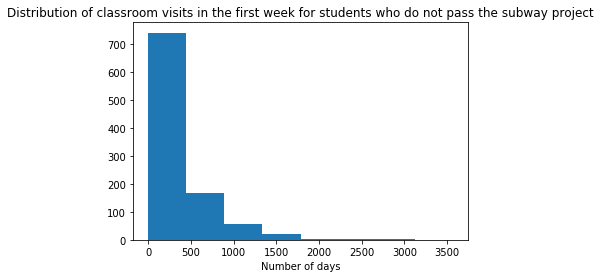

In [76]:
## 至少改进一幅之前的可视化图表，尝试导入 seaborn 库使你的图表看起来更美观。
## 加入轴标签及表头，并修改一个或多个 hist() 内的变量。

import seaborn as sns
'''seaborn will aumomatically beautify graph'''

plt.hist(total_minutes, bins=8)
plt.xlabel('Number of days')
plt.title('Distribution of classroom visits in the first week ' + 
          'for students who do not pass the subway project')

